# Fetching SDSS images for source classification

This notebook

- makes an SQL query to the SDSS DR12 database (using its [API](http://skyserver.sdss.org/dr12/en/help/docs/api.aspx)) to create a catalog, 
- downloads the FITS files,
- uses [Montage](http://montage.ipac.caltech.edu/) (and [montage wrapper](http://www.astropy.org/montage-wrapper/) to align each image to the image in the $r$-band, and
- uses [Sextractor](http://www.astromatic.net/software/sextractor) to find the pixel position of objects, and
- converts the fluxes in FITS files to [luptitudes](http://www.sdss.org/dr12/algorithms/magnitudes/#asinh).

This [Docker image](https://github.com/EdwardJKim/deeplearning4astro/tree/master/docker) has all packages necessary to run this notebook.

In [1]:
%matplotlib inline

import os
import shutil
import requests
import json
import bz2
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import montage_wrapper as mw
from astropy.io import fits
from astropy import wcs

## SQL

For demonstration purposes, we use the SDSS [API](http://skyserver.sdss.org/dr12/en/help/docs/api.aspx) to create an SQL query. However, it's not suitable for making a query with a large number of objects, so the following functions uses only a 1 sq. deg. patch of sky.

[SpecObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecObjAll+U)

[PhotoObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U)

Although there exists a precomputed join ([SpecPhotoAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecPhotoAll+U)) between the PhotoOjbAll and SpecObjAll tables, we do a join ourselves because SpecPhotoAll doesn't have some attributes we want, e.g. the clean photometry flag or the light profiles ("expRad" and "deVRad").

In [2]:
def sample_one_sq_deg(ra, dec, n=500, dr="dr12", timeout=60):
    
    url = "http://skyserver.sdss.org/{}/en/tools/search/x_sql.aspx".format(dr)
    payload = {
        "format": "json",
        "cmd": """
            SELECT TOP {0} spec.specObjID, phot.objID,
                spec.ra, spec.dec,
                spec.class,
                spec.z, spec.zErr,
                phot.rerun, phot.run, phot.camcol, phot.field,
                phot.dered_u, phot.dered_g, phot.dered_r, phot.dered_i, phot.dered_z,
                phot.psfMag_u, phot.psfMag_g, phot.psfMag_r, phot.psfMag_i, phot.psfMag_z,
                phot.cModelMag_u, phot.cModelMag_g, phot.cModelMag_r, phot.cModelMag_i, phot.cModelMag_z
            FROM SpecObjAll AS spec
            JOIN PhotoObjAll AS phot
            ON spec.specObjID = phot.specObjID
            WHERE
                phot.clean = 1
                AND spec.zWarning = 0
                AND spec.ra >= {1}
                AND spec.ra < {2}
                AND spec.dec >= {3}
                AND spec.dec < {4}
                AND phot.dered_r > 0 and phot.dered_r < 40
                AND phot.expRad_r < 30
                AND phot.deVRad_r < 30
                AND spec.zErr < 0.1
                AND spec.z < 2
            ORDER BY NEWID()
        """.format(n, ra, ra + 1, dec, dec + 1).strip()
    }
    
    try:
        resp = requests.post(url, params=payload, timeout=timeout)
    except requests.exceptions.RequestException as e:
        print(e)
        return None

    data = resp.json()[0]['Rows']
    
    df = pd.DataFrame(data)

    return df

For a large number of objects, you can use [CasJobs](http://skyserver.sdss.org/casjobs) as follows.

```sql
SELECT spec.specObjID, phot.objID,
    spec.ra, spec.dec,
    spec.class,
    spec.z, spec.zErr,
    phot.rerun, phot.run, phot.camcol, phot.field,
    phot.dered_u, phot.dered_g, phot.dered_r, phot.dered_i, phot.dered_z,
    phot.psfMag_u, phot.psfMag_g, phot.psfMag_r, phot.psfMag_i, phot.psfMag_z,
    cModelMag_u, cModelMag_g, cModelMag_r, cModelMag_i, cModelMag_z
INTO mydb.DR12_spec_phot_all
FROM SpecObjAll AS spec
JOIN PhotoObjAll AS phot
ON spec.specObjID = phot.specObjID
WHERE
    phot.clean = 1
    AND spec.zWarning = 0
    AND phot.dered_r > 0 and phot.dered_r < 40
    AND phot.expRad_r < 30
    AND phot.deVRad_r < 30
    AND spec.zErr < 0.1
    AND spec.z < 2
```

From this table `mydb.DR12_spec_phot_all`, we randomly choose 100,000 objects:

```sql
SELECT TOP 100000 *
INTO mydb.DR12_spec_phot_sample
FROM mydb.DR12_spec_phot_all
ORDER BY NEWID()
```

In [3]:
df = sample_one_sq_deg(170, 0)

df.to_csv("objects.csv", index=False)

print(df)

     cModelMag_g  cModelMag_i  cModelMag_r  cModelMag_u  cModelMag_z  camcol  \
0       18.46014     17.06534     17.46124     19.99211     16.72760       5   
1       18.15582     16.88741     17.23780     19.93553     16.60979       4   
2       18.60643     17.22590     17.69707     19.25379     17.01235       5   
3       17.79549     16.51409     16.95488     18.81517     16.20511       4   
4       17.54909     16.95061     17.21211     18.39828     16.90816       4   
5       18.53003     17.29572     17.70860     20.44893     17.01626       4   
6       18.37847     17.38651     17.75914     19.53575     17.08701       5   
7       18.00722     17.24593     17.55705     17.92757     17.13756       5   
8       17.60681     16.54409     16.92439     18.63726     16.25527       4   
9       20.88450     20.54552     20.63847     21.38969     20.57498       4   
10      18.00244     17.71626     17.95517     18.34775     17.71871       5   
11      23.26501     19.98966     21.415

## FITS images

Images and derived catalog data are described on the imaging data page. You can use a SkyServer search or the file window_flist.fits file to identify which RERUN-RUN-CAMCOL-FIELD overlaps your region of interest. Then download the matching calibObj files (catalog data) or frame files (calibrated imaging data), e.g., for RERUN 301, RUN 2505, CAMCOL 3, FIELD 38, the r-band image is:

```shell
$ wget --spider http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/2505/3/frame-r-002505-3-0038.fits.bz2
```

In [4]:
def fetch_fits(df):

    bands = [c for c in 'ugriz']
    
    run = df[["rerun", "run", "camcol", "field"]].drop_duplicates()
    
    if not os.path.exists("images/raw"):
        os.makedirs("images/raw")

    for i, r in run.iterrows():
        
        for band in bands:
            url = "http://data.sdss3.org/sas/dr12/boss/photoObj/frames/{0}/{1}/{2}/".format(
                r.rerun, r.run, r.camcol, r.field, band)
            filename = "frame-{4}-{1:06d}-{2}-{3:04d}.fits.bz2".format(
                r.rerun, r.run, r.camcol, r.field, band)
            filepath = os.path.join("images/raw", filename)
            
            if os.path.exists(filepath.replace(".bz2", "")):
                print("Skipping {}".format(filename))
            else:
                print("Downloading and extracting {}".format(filename))
                
                resp = requests.get(url + filename, stream=True)
            
                with open(filepath.replace(".bz2", ""), "wb") as f:
                    img = bz2.decompress(resp.content)
                    f.write(img)

In [5]:
fetch_fits(df)

Skipping frame-u-006793-5-0065.fits.bz2
Skipping frame-g-006793-5-0065.fits.bz2
Skipping frame-r-006793-5-0065.fits.bz2
Skipping frame-i-006793-5-0065.fits.bz2
Skipping frame-z-006793-5-0065.fits.bz2
Skipping frame-u-000756-4-0367.fits.bz2
Skipping frame-g-000756-4-0367.fits.bz2
Skipping frame-r-000756-4-0367.fits.bz2
Skipping frame-i-000756-4-0367.fits.bz2
Skipping frame-z-000756-4-0367.fits.bz2
Skipping frame-u-006793-5-0067.fits.bz2
Skipping frame-g-006793-5-0067.fits.bz2
Skipping frame-r-006793-5-0067.fits.bz2
Skipping frame-i-006793-5-0067.fits.bz2
Skipping frame-z-006793-5-0067.fits.bz2
Skipping frame-u-006793-4-0067.fits.bz2
Skipping frame-g-006793-4-0067.fits.bz2
Skipping frame-r-006793-4-0067.fits.bz2
Skipping frame-i-006793-4-0067.fits.bz2
Skipping frame-z-006793-4-0067.fits.bz2
Skipping frame-u-000756-4-0363.fits.bz2
Skipping frame-g-000756-4-0363.fits.bz2
Skipping frame-r-000756-4-0363.fits.bz2
Skipping frame-i-000756-4-0363.fits.bz2
Skipping frame-z-000756-4-0363.fits.bz2


In [6]:
ref_images = []

run = df[["rerun", "run", "camcol", "field"]].drop_duplicates()
for row in run.iterrows():
    r = row[1]
    filename = "frame-r-{1:06d}-{2}-{3:04d}.fits".format(r.rerun, r.run, r.camcol, r.field)
    ref_images.append(filename)

print(ref_images)

['frame-r-006793-5-0065.fits', 'frame-r-000756-4-0367.fits', 'frame-r-006793-5-0067.fits', 'frame-r-006793-4-0067.fits', 'frame-r-000756-4-0363.fits', 'frame-r-000756-5-0363.fits', 'frame-r-006793-5-0068.fits', 'frame-r-006793-4-0069.fits', 'frame-r-000756-5-0364.fits', 'frame-r-006793-5-0064.fits', 'frame-r-000756-4-0365.fits', 'frame-r-006793-4-0063.fits', 'frame-r-006793-6-0068.fits', 'frame-r-006793-4-0065.fits', 'frame-r-006793-4-0066.fits', 'frame-r-006793-6-0065.fits', 'frame-r-000756-5-0368.fits', 'frame-r-000756-4-0362.fits', 'frame-r-000756-5-0366.fits', 'frame-r-006793-5-0066.fits', 'frame-r-000756-5-0365.fits', 'frame-r-002141-4-0188.fits', 'frame-r-006793-4-0064.fits', 'frame-r-000756-5-0367.fits', 'frame-r-006793-6-0064.fits', 'frame-r-006793-6-0063.fits', 'frame-r-000756-4-0366.fits', 'frame-r-000756-5-0362.fits', 'frame-r-006793-5-0063.fits', 'frame-r-006793-6-0067.fits', 'frame-r-000756-4-0364.fits', 'frame-r-006793-6-0066.fits', 'frame-r-000756-4-0368.fits', 'frame-r-

## Montage

### Converting ra and dec values to pixel positions

[re-projection](http://montage.ipac.caltech.edu/docs/algorithms.html)

Montage sometimes throws the following error:

```
MontageError: mProject: File (/notebooks/shared/images/raw/frame-z-007712-3-0338.fits) is not a FITS image
```

When this happens, deleting the offending file and reruning `fetch_fits()` fixes the error.

In [7]:
if not os.path.exists("images/header"):
    os.makedirs("images/header")

if not os.path.exists("images/registered"):
    os.makedirs("images/registered")

for image in ref_images:
    
    print("Processing {}...".format(image))

    for b in "ugriz":
        frame_path = os.path.join("images/raw", image.replace("frame-r-", "frame-{}-").format(b))
        registered_path = os.path.join("images/registered", image.replace("frame-r-", "registered-{}-").format(b))
        
        if not os.path.exists(registered_path):
            header = os.path.join("images/header", image.replace("frame", "header").replace(".fits", ".hdr"))
            mw.commands.mGetHdr(os.path.join("images/raw", image), header)
            mw.reproject(frame_path, registered_path, header=header, exact_size=True, common=True, silent_cleanup=True)

Processing frame-r-006793-5-0065.fits...
Processing frame-r-000756-4-0367.fits...
Processing frame-r-006793-5-0067.fits...
Processing frame-r-006793-4-0067.fits...
Processing frame-r-000756-4-0363.fits...
Processing frame-r-000756-5-0363.fits...
Processing frame-r-006793-5-0068.fits...
Processing frame-r-006793-4-0069.fits...
Processing frame-r-000756-5-0364.fits...
Processing frame-r-006793-5-0064.fits...
Processing frame-r-000756-4-0365.fits...
Processing frame-r-006793-4-0063.fits...
Processing frame-r-006793-6-0068.fits...
Processing frame-r-006793-4-0065.fits...
Processing frame-r-006793-4-0066.fits...
Processing frame-r-006793-6-0065.fits...
Processing frame-r-000756-5-0368.fits...
Processing frame-r-000756-4-0362.fits...
Processing frame-r-000756-5-0366.fits...
Processing frame-r-006793-5-0066.fits...
Processing frame-r-000756-5-0365.fits...
Processing frame-r-002141-4-0188.fits...
Processing frame-r-006793-4-0064.fits...
Processing frame-r-000756-5-0367.fits...
Processing frame

In [8]:
def convert_catalog_to_pixels(df):

    pixels = pd.DataFrame()

    for i, r in df.iterrows():

        fits_file = "registered-r-{1:06d}-{2}-{3:04d}.fits".format(
            r.rerun, r.run, r.camcol, r.field)
        fits_path = os.path.join("images/registered", fits_file)
            
        hdulist = fits.open(fits_path)

        w = wcs.WCS(hdulist[0].header, relax=False)
        
        px, py = w.all_world2pix(r.ra, r.dec, 1)

        pixels.loc[i, "file"] = fits_file
        pixels.loc[i, "px"] = px
        pixels.loc[i, "py"] = py
        pixels.loc[i, "class"] = r["class"]
        
        pixel_list = fits_file.replace(".fits", ".list")
        pixel_path = os.path.join("catalog", pixel_list)
        
    for fits_file in pixels.file.unique():
        pixel_list = fits_file.replace(".fits", ".list")
        pixel_path = os.path.join("catalog", pixel_list)
        p = pixels[pixels.file == fits_file]
        p[["px", "py", "class"]].to_csv(pixel_path, sep= " ", header=False)

In [9]:
convert_catalog_to_pixels(df)

RADECSYS is non-standard, use RADESYSa. [astropy.wcs.wcs]
RADECSYS is non-standard, use RADESYSa.


## Sextractor

In [10]:
%%writefile default.conv
CONV NORM
# 3x3 ``all-ground'' convolution mask with FWHM = 2 pixels.
1 2 1
2 4 2
1 2 1

Overwriting default.conv


In [11]:
%%writefile default.param
XMIN_IMAGE               Minimum x-coordinate among detected pixels                [pixel]
YMIN_IMAGE               Minimum y-coordinate among detected pixels                [pixel]
XMAX_IMAGE               Maximum x-coordinate among detected pixels                [pixel]
YMAX_IMAGE               Maximum y-coordinate among detected pixels                [pixel]
VECTOR_ASSOC(1)          #ASSOCiated parameter vector

Overwriting default.param


In [12]:
%%writefile default.sex
#-------------------------------- Catalog ------------------------------------
 
CATALOG_NAME     test.cat       # name of the output catalog
CATALOG_TYPE     ASCII_HEAD     # NONE,ASCII,ASCII_HEAD, ASCII_SKYCAT,
                                # ASCII_VOTABLE, FITS_1.0 or FITS_LDAC
PARAMETERS_NAME  default.param  # name of the file containing catalog contents
 
#------------------------------- Extraction ----------------------------------
 
DETECT_TYPE      CCD            # CCD (linear) or PHOTO (with gamma correction)
DETECT_MINAREA   3              # min. # of pixels above threshold
DETECT_THRESH    1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2
ANALYSIS_THRESH  1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2
 
FILTER           Y              # apply filter for detection (Y or N)?
FILTER_NAME      default.conv   # name of the file containing the filter
 
DEBLEND_NTHRESH  32             # Number of deblending sub-thresholds
DEBLEND_MINCONT  0.005          # Minimum contrast parameter for deblending
 
CLEAN            Y              # Clean spurious detections? (Y or N)?
CLEAN_PARAM      1.0            # Cleaning efficiency
 
MASK_TYPE        CORRECT        # type of detection MASKing: can be one of
                                # NONE, BLANK or CORRECT

#------------------------------ Photometry -----------------------------------
 
PHOT_APERTURES   5              # MAG_APER aperture diameter(s) in pixels
PHOT_AUTOPARAMS  2.5, 3.5       # MAG_AUTO parameters: <Kron_fact>,<min_radius>
PHOT_PETROPARAMS 2.0, 3.5       # MAG_PETRO parameters: <Petrosian_fact>,
                                # <min_radius>

SATUR_LEVEL      50000.0        # level (in ADUs) at which arises saturation
SATUR_KEY        SATURATE       # keyword for saturation level (in ADUs)
 
MAG_ZEROPOINT    0.0            # magnitude zero-point
MAG_GAMMA        4.0            # gamma of emulsion (for photographic scans)
GAIN             0.0            # detector gain in e-/ADU
GAIN_KEY         GAIN           # keyword for detector gain in e-/ADU
PIXEL_SCALE      1.0            # size of pixel in arcsec (0=use FITS WCS info)
 
#------------------------- Star/Galaxy Separation ----------------------------
 
SEEING_FWHM      1.2            # stellar FWHM in arcsec
STARNNW_NAME     default.nnw    # Neural-Network_Weight table filename
 
#------------------------------ Background -----------------------------------
 
BACK_SIZE        64             # Background mesh: <size> or <width>,<height>
BACK_FILTERSIZE  3              # Background filter: <size> or <width>,<height>
 
BACKPHOTO_TYPE   GLOBAL         # can be GLOBAL or LOCAL
 
#------------------------------ Check Image ----------------------------------
 
CHECKIMAGE_TYPE  SEGMENTATION   # can be NONE, BACKGROUND, BACKGROUND_RMS,
                                # MINIBACKGROUND, MINIBACK_RMS, -BACKGROUND,
                                # FILTERED, OBJECTS, -OBJECTS, SEGMENTATION,
                                # or APERTURES
CHECKIMAGE_NAME  check.fits     # Filename for the check-image
 
#--------------------- Memory (change with caution!) -------------------------
 
MEMORY_OBJSTACK  3000           # number of objects in stack
MEMORY_PIXSTACK  300000         # number of pixels in stack
MEMORY_BUFSIZE   1024           # number of lines in buffer
 
#----------------------------- Miscellaneous ---------------------------------
 
VERBOSE_TYPE     NORMAL         # can be QUIET, NORMAL or FULL
HEADER_SUFFIX    .head          # Filename extension for additional headers
WRITE_XML        N              # Write XML file (Y/N)?
XML_NAME         sex.xml        # Filename for XML output

#----------------------------- ASSOC parameters ---------------------------------

ASSOC_NAME       sky.list       # name of the ASCII file to ASSOCiate, the expected pixel 
                                # coordinates list given as [id, xpos, ypos]
ASSOC_DATA       1              # columns of the data to replicate (0=all), replicate id
                                # of the object in the SExtractor output file
ASSOC_PARAMS     2,3            # columns of xpos,ypos[,mag] in the expected pixel
                                # coordinates list
ASSOC_RADIUS     2.0            # cross-matching radius (pixels)
ASSOC_TYPE       NEAREST        # ASSOCiation method: FIRST, NEAREST, MEAN,
                                # MAG_MEAN, SUM, MAG_SUM, MIN or MAX
ASSOCSELEC_TYPE  MATCHED        # ASSOC selection type: ALL, MATCHED or -MATCHED

Overwriting default.sex


In [13]:
cat = pd.DataFrame()

registered_all = [f.replace("frame-", "registered-") for f in ref_images]

for f in registered_all:
    
    fpath = os.path.join("images/registered", f)
    
    list_file = f.replace(".fits", ".list")
    list_path = os.path.join("catalog", list_file)

    with open("default.sex", "r") as default, open("default.sex.temp", "w") as temp:
        for line in default:
            line = re.sub(
                r"^ASSOC_NAME\s+sky.list",
                "ASSOC_NAME       {}".format(list_file),
                line
            )
            temp.write(line)

    shutil.copy(list_path, os.getcwd())

    !sex -c default.sex.temp -VERBOSE_TYPE quiet $fpath
    
    os.remove("default.sex.temp")

    try:
        assoc = pd.read_csv(
            "test.cat",
            comment="#",
            header=None,
            delim_whitespace=True,
            names=["xmin", "ymin", "xmax", "ymax", "match"]
        )
        assoc["file"] = f
        cat = cat.append(assoc)
    except:
        pass
    
    os.remove(os.path.join(os.getcwd(), list_file))
        
cat["class"] = df.iloc[cat["match"]]["class"].values
cat["specObjID"] = df.iloc[cat["match"]]["specObjID"].values
cat = cat.reset_index(drop=True)

print(cat)

     xmin  ymin  xmax  ymax  match                             file   class  \
0    1580   216  1605   257    166  registered-r-006793-5-0065.fits  GALAXY   
1     134   176   139   181     89  registered-r-006793-5-0065.fits  GALAXY   
2    1934   230  1966   254    206  registered-r-006793-5-0065.fits  GALAXY   
3     920   252   927   258    264  registered-r-006793-5-0065.fits    STAR   
4      84   442    89   447    321  registered-r-006793-5-0065.fits    STAR   
5    1759   780  1792   831    302  registered-r-006793-5-0065.fits  GALAXY   
6    1318   750  1324   756    109  registered-r-006793-5-0065.fits    STAR   
7    1711   736  1717   744     20  registered-r-006793-5-0065.fits  GALAXY   
8    1221  1276  1232  1289     82  registered-r-006793-5-0065.fits  GALAXY   
9      92  1184   126  1208      0  registered-r-006793-5-0065.fits  GALAXY   
10   1574  1003  1580  1011    233  registered-r-006793-5-0065.fits     QSO   
11    496   196   567   227    202  registered-r-000

## Converting fluxes to magnitudes

In [14]:
def nanomaggie_to_luptitude(array, band):
    '''
    Converts nanomaggies (flux) to luptitudes (magnitude).

    http://www.sdss.org/dr12/algorithms/magnitudes/#asinh
    http://arxiv.org/abs/astro-ph/9903081
    '''
    b = {
        'u': 1.4e-10,
        'g': 0.9e-10,
        'r': 1.2e-10,
        'i': 1.8e-10,
        'z': 7.4e-10
    }
    nanomaggie = array * 1.0e-9 # fluxes are in nanomaggies

    luptitude = -2.5 / np.log(10) * (np.arcsinh((nanomaggie / (2 * b[band]))) + np.log(b[band]))
    
    return luptitude

## Creating cutout images

In [15]:
def save_cutout(df, size=32):

    if not os.path.exists("result"):                                                                                               
        os.makedirs("result")                                                                                                      
                                                                                                                                   
    saved = []                                                                                                                     
                                                                                                                                   
    for i, row in df.iterrows():                                                                                                   
        
        pixels_ok = True
        array = np.zeros((5, size, size))                                                                          
                                                                                                                                   
        for j, b in enumerate("ugriz"):                                                                                            
                                                                                                                                   
            fpath = os.path.join("images/registered", row.file)                                                                    
            image_data = fits.getdata(fpath.replace("-r-", "-{}-".format(b)))                                                      
                                                                                                                                   
            y0, x0, y1, x1 = row[0:4].values                                                                                       
                                                                                                                                   
            right = max(0.5 * (size - (x1 - x0)), 1)                                                                               
            left = max(0.5 * (size - (x1 - x0)), 0)                                                                                
            up = max(0.5 * (size - (y1 - y0)), 0)                                                                                  
            down = max(0.5 * (size - (y1 - y0)), 1)                                                                                
                                                                                                                                   
            cut_out = image_data[x0 - right: x1 + left, y0 - down: y1 + up]                                                        
                                                                                                                                   
            if (np.isnan(array).sum() == 0
                and cut_out.shape[0] == size
                and cut_out.shape[1] == size):                                                              
                                                                                                                                   
                cut_out = nanomaggie_to_luptitude(cut_out, b)                                                                                                                                                                                 
                array[j, :, :] = cut_out
            else:
                pixels_ok = False
        
        save_path = os.path.join("result", "{}.{}.npy".format(row["class"], row["specObjID"]))                                     
        if os.path.exists(save_path):
            os.remove(save_path)

        if pixels_ok:
            np.save(save_path, array)                                                                                              
            saved.append((row["class"], row["specObjID"]))                                                                             
                                                                                                                                   
    print("{} files saved.".format(len(saved))) 
    
    return saved

In [16]:
saved = save_cutout(cat, size=48)

265 files saved.


## Sample images

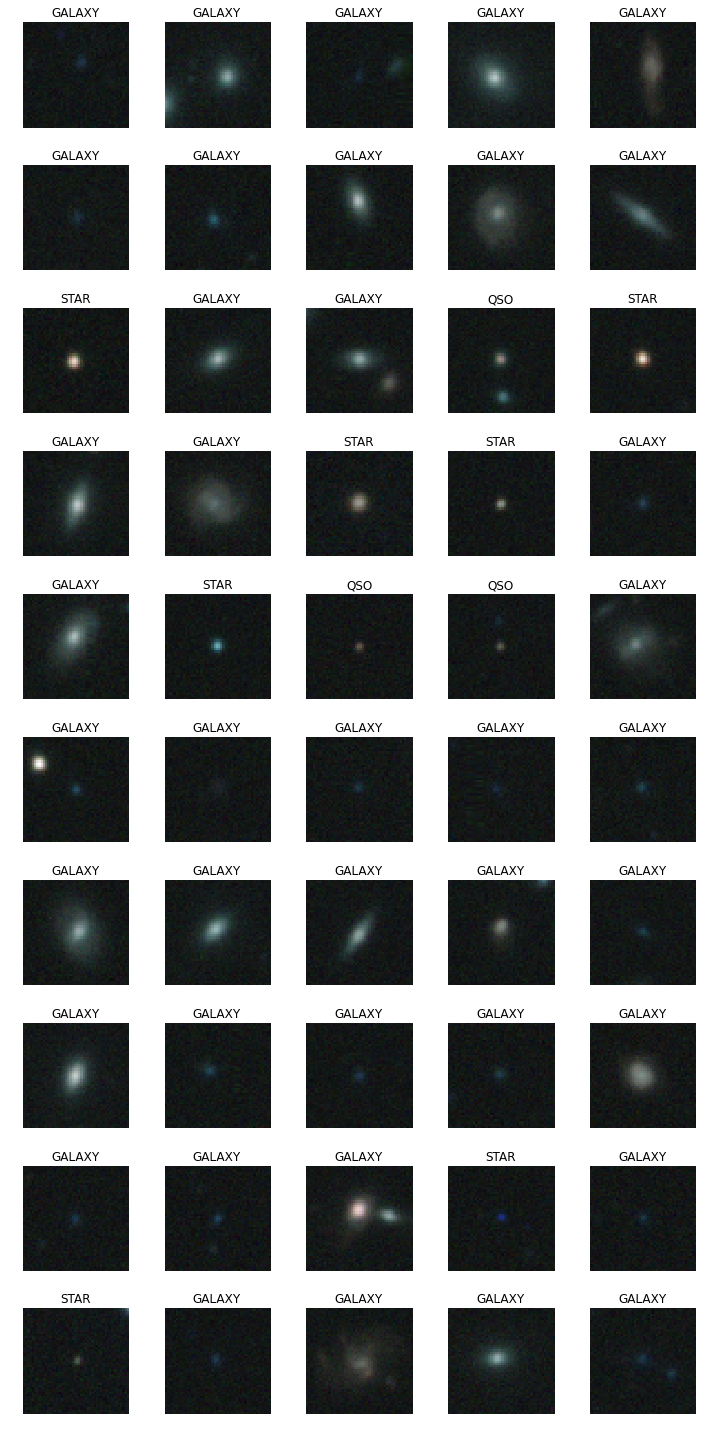

In [17]:
size = 48
nrow = 10
ncol = 5

cutouts = os.listdir("result")[:nrow * ncol]
np.random.shuffle(cutouts)

fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 2))
fig.tight_layout()

rgb = np.zeros((nrow * ncol, size, size, 3))
for i, f in enumerate(cutouts):
    fpath = os.path.join("result", f)
    cutout = np.load(fpath)
    rgb[i, :, :, :] = np.rollaxis(cutout[1:4, :, :], 0, 3) # 1:4 for "gri" in "ugriz"

for j in range(3):
    v = rgb[:, :, :, j]
    rgb[:, :, :, j] = (v - v.min()) / (v.max() - v.min()) * 255

# invert values so that the background is black
rgb = 255 - rgb.astype(np.uint8)

for i, f in enumerate(cutouts):
    row, col = i // ncol, i % ncol
    ax[row, col].imshow(rgb[i, :, :, :], interpolation="nearest")
    ax[row, col].axis("off")
    ax[row, col].set_title(f.split(".")[0])